# 🔰PyTorchでニューラルネットワーク基礎 #11 【時系列分析・系列変換】

## 内容
* Qiitaの記事と連動しています
* LSTMを用いた系列変換モデル（エンコーダー・デコーダーモデル）を使って日経225の始値を5期間分予測させる演習

## データについて
* データ：data/nikkei_225.csv
* 2021年から2025年6月中旬くらいのデータ
* 日経225データはyfinanceを利用して取得

## ちょっとした注意点
* LSTMを２回利用するのでCPU環境だとちょっとつらいかも（エンコーダーとデコーダーの窓サイズを小さくするなどの変更をすると演習は可能）
* GPU（ゲーム用ノートPC搭載のGPUでもOK）あると高速に学習できる
* Google ColaboratoryでももちろんOK

In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSVファイルの読み込み
data = pd.read_csv("./data/nikkei_225.csv")
data.head(10)

,Date,Open,High,Low,Close,Volume
0,2021-01-04,27575.57,27602.11,27042.32,27258.38,51500000
1,2021-01-05,27151.38,27279.78,27073.46,27158.63,55000000
2,2021-01-06,27102.85,27196.40,27002.18,27055.94,72700000
3,2021-01-07,27340.46,27624.73,27340.46,27490.13,98900000
4,2021-01-08,27720.14,28139.03,27667.75,28139.03,84900000
5,2021-01-12,28004.37,28287.37,27899.45,28164.34,78800000
6,2021-01-13,28140.10,28503.43,28133.59,28456.59,70900000
7,2021-01-14,28442.73,28979.53,28411.58,28698.26,81900000
8,2021-01-15,28777.47,28820.50,28477.03,28519.18,74100000
9,2021-01-18,28238.68,28349.97,28111.54,28242.21,51900000


In [3]:
# 日経225の値を10,000円で割り算して値を小さくする
scaling_factor = 10_000
x_open = data["Open"]/scaling_factor
x_high = data["High"]/scaling_factor
x_low = data["Low"]/scaling_factor
x_close = data["Close"]/scaling_factor

In [4]:
win_size = 5       # エンコーダーデータの窓サイズ
dec_win_size = 5   # デコーダーデータの窓サイズ
XO = [x_open[start:start+win_size] for start in range(len(data)-win_size-dec_win_size)]
XH = [x_high[start:start+win_size] for start in range(len(data)-win_size-dec_win_size)]
XL = [x_low[start:start+win_size] for start in range(len(data)-win_size-dec_win_size)]
XC = [x_close[start:start+win_size] for start in range(len(data)-win_size-dec_win_size)]
# 教師データ
TO = [x_open[start:start+dec_win_size] for start in range(win_size, len(data)-dec_win_size)]

xo = np.array(XO)
xh = np.array(XH)
xl = np.array(XL)
xc = np.array(XC)


t  = np.array(TO)
xo = xo.reshape(xo.shape[0], xo.shape[1], 1)
xh = xh.reshape(xh.shape[0], xh.shape[1], 1)
xl = xl.reshape(xl.shape[0], xl.shape[1], 1)
xc = xc.reshape(xc.shape[0], xc.shape[1], 1)


t   = t.reshape(t.shape[0], t.shape[1])
x = np.concatenate([xo, xh, xl, xc], axis=2)
x.shape, t.shape

((1082, 5, 4), (1082, 5))

## 系列変換モデルを利用したネットワークの作成と学習

In [5]:
import torch
import torch.nn as nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

x = torch.FloatTensor(x).to(device)
t = torch.FloatTensor(t).to(device)


period = 100
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([982, 5, 4]),
 torch.Size([100, 5, 4]),
 torch.Size([982, 5]),
 torch.Size([100, 5]))

### ネットワークの構造


In [7]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        # エンコーダー
        self.enc_lstm = nn.LSTM(input_size=4, hidden_size=100, num_layers=1, batch_first=True)
        # デコーダー
        self.dec_lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=100, out_features=50)
        self.act = nn.LeakyReLU()
        self.fc2 = nn.Linear(in_features=50, out_features=1)
    
    def forward(self, x):
        # エンコーダー処理
        _, (h, c) = self.enc_lstm(x)      
        # デコーダー用の初期入力（xの最後のタイムステップ (1,2,3,4,5)なら５が入力される）
        decoder_input = x[:, -1:, 0].unsqueeze(2)  # (batch_size, 1, 1)
        # 5日目のClose価格を初期入力として使用
        #decoder_input = x[:, -1:, 3].unsqueeze(2)  # Close価格を使用
        hidden = h[-1,:,:].unsqueeze(0)
        cell   = c[-1,:,:].unsqueeze(0)
        # 予測結果を格納
        outputs = []
        # デコーダーでの予測ループ
        for t in range(dec_win_size):
            o, (hidden, cell) = self.dec_lstm(decoder_input, (hidden, cell))
            last_output = hidden[-1]      # 最後のステップの出力 o[:,-1,:]でも同じ 
            h = self.fc1(last_output)
            h = self.act(h)
            y = self.fc2(h)
            outputs.append(y)
            decoder_input = y.unsqueeze(1)  # (batch_size, 1, 1)
            
        # 予測結果を結合
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [8]:
model = DNN()
model.to(device)

DNN(
  (enc_lstm): LSTM(4, 100, batch_first=True)
  (dec_lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
# ハイパーパラメータ
LOOP = 5_000 # 1000

In [10]:
# 損失関数と最適化関数の定義
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

In [11]:
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y, t_train)
    if (epoch+1)%1000 == 0:
        print(f"{epoch}\tloss: {loss.item()}")
    loss.backward()
    optimizer.step()

999	loss: 0.004292050842195749
1999	loss: 0.003926232922822237
2999	loss: 0.0037431030068546534
3999	loss: 0.003598985727876425
4999	loss: 0.00354005373083055


## テストデータでグラフを描画
* x_test : テスト用の入力データ
* t_test : テスト用の教師データ

In [13]:
import matplotlib.pyplot as plt
import japanize_matplotlib


# 予測値のリスト
# y_test[i]は５期間の予測値のリスト
with torch.inference_mode():
    output = model(x_test)
y_test = output.cpu().detach().numpy()

# 実測値のリスト
# 今回はdec_win_sizeの先頭部分を集めれば実測値となる
real_list = [item[0].detach().cpu().numpy() for item in t_test]

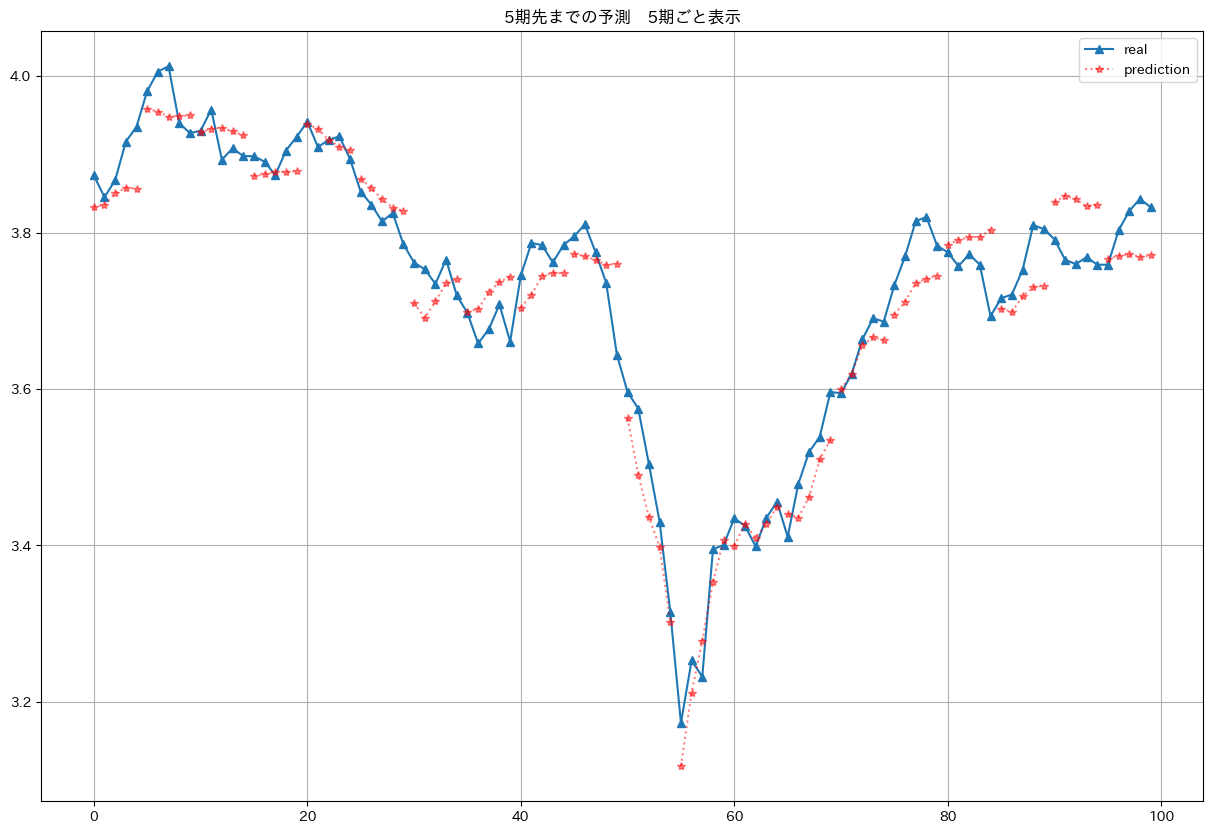

In [15]:
e = period

plt.figure(figsize=(15,10))

plt.title(f"{dec_win_size}期先までの予測　5期ごと表示")
plt.plot(real_list[:e], label="real", marker="^")
for i in range(0,e-dec_win_size+1,5):
    plt.plot(range(i, i + len(y_test[i])), y_test[i], linestyle="dotted", label="prediction" if i == 0 else "", marker="*", color="red", alpha=0.5)
plt.legend()
plt.grid()
plt.show()